In [2]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('apw-notebook')
%matplotlib inline
import h5py

#from __future__ import print_function

from keras.models import Sequential
from keras.layers import Convolution1D, Convolution2D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout, Flatten

Using TensorFlow backend.


In [80]:
# test data
filename_data = "testdata.h5"
dir_data = "data001/"

# sim data
filename_data = "apogee-spectra.h5"
dir_data = "data002/"


In [159]:
dir_base = "/Users/nord/Dropbox/TheCNNon/"
dir_data_full = dir_base + dir_data
file_data = dir_data_full + filename_data

In [208]:
with h5py.File(file_data, 'r') as f:
    X = f['X'][:]#.astype(np.float32)
    y = f['y'][:]#.astype(np.float32)

y = y[:,0:1]
y = y - min(y)
y = y / max(y)
print min(y), max(y)

X[np.isnan(X)] = 0.

[ 0.] [ 1.]


(array([ 4.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  4.]),
 array([ 0.5 ,  0.56,  0.62,  0.68,  0.74,  0.8 ,  0.86,  0.92,  0.98,
         1.04,  1.1 ]),
 <a list of 10 Patch objects>)

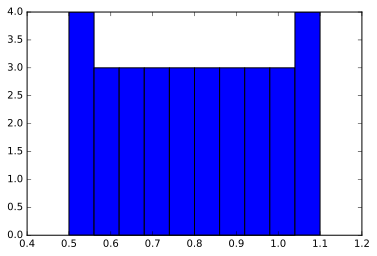

In [223]:
plt.hist(y)

In [198]:
n_train = 1024
n_valid = 1024
nb_epoch = 1
n_test = X.shape[0] - n_train - n_valid
print("Train, Valid, Test", n_train, n_valid, n_test)

('Train, Valid, Test', 1024, 1024, 2048)


In [199]:
X_train = X[:n_train]
y_train = y[:n_train,:1]

X_valid = X[n_train:n_train+n_valid]
y_valid = y[n_train:n_train+n_valid,:1]

X_test = X[n_train+n_valid:]
y_test = y[n_train+n_valid:,:1]
n_objects, n_pixels = X_train.shape
n_objects, n_pixels


(1024, 8575)

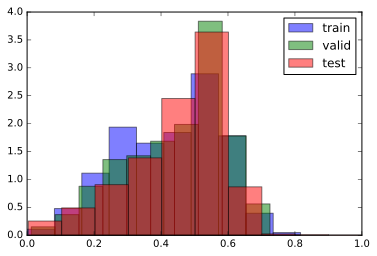

In [222]:
plt.hist(y_train, alpha=0.5, normed=True, label='train');
plt.hist(y_valid, alpha=0.5, normed=True, label='valid');
plt.hist(y_test, alpha=0.5, normed=True, label='test');
plt.legend()

In [215]:
model = Sequential()

model.add(Convolution1D(nb_filter=128, filter_length=1000, input_dim=1))
model.add(Activation('sigmoid'))
model.add(MaxPooling1D(pool_length=500))

# We add a vanilla hidden layer:
# model.add(Dense(128))
# model.add(Dropout(0.5))

model.add(Dense(48))
model.add(Dropout(0.5))
#model.add(Activation('sigmoid'))

model.add(GlobalMaxPooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))

optimizer = 'adadelta'
#optimizer="rmsprop"
model.compile(loss="mse", optimizer=optimizer)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_23 (Convolution1D) (None, None, 128)     128128      convolution1d_input_23[0][0]     
____________________________________________________________________________________________________
activation_45 (Activation)       (None, None, 128)     0           convolution1d_23[0][0]           
____________________________________________________________________________________________________
maxpooling1d_23 (MaxPooling1D)   (None, None, 128)     0           activation_45[0][0]              
____________________________________________________________________________________________________
dense_45 (Dense)                 (None, None, 48)      6192        maxpooling1d_23[0][0]            
___________________________________________________________________________________________

In [216]:
history = model.fit(X_train.reshape(len(X_train), n_pixels, 1), y_train, nb_epoch=nb_epoch, batch_size=32,
          validation_data=(X_valid.reshape(len(X_valid), n_pixels, 1), y_valid), verbose=True)

Train on 1024 samples, validate on 1024 samples
Epoch 1/1
1024/1024 [==============================] - 176s - loss: 0.0311 - val_loss: 0.0248

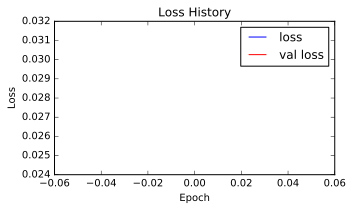

In [217]:
# History
hist = history.history
loss = hist['loss']
val_loss = hist["val_loss"]
epochs = np.arange(nb_epoch)
figsize=(5,3)
fig, axis1 = plt.subplots(figsize=figsize)
plot1_loss = axis1.plot(epochs, loss, 'b', label='loss')
plot1_val_loss = axis1.plot(epochs, val_loss, 'r', label="val loss")
plots = plot1_loss + plot1_val_loss
labs = [l.get_label() for l in plots]
axis1.set_xlabel('Epoch')
axis1.set_ylabel('Loss')
plt.title("Loss History")
plt.tight_layout()
axis1.legend(loc='upper right')


In [172]:
#score = model.evaluate(X_test.reshape(len(X_test), n_pixels, 1), y_test, batch_size=16)

2048/2048 [==============================] - 100s     

In [218]:
y_pred = model.predict(X_test.reshape(len(X_test), n_pixels, 1), verbose=True)

2048/2048 [==============================] - 2291s     

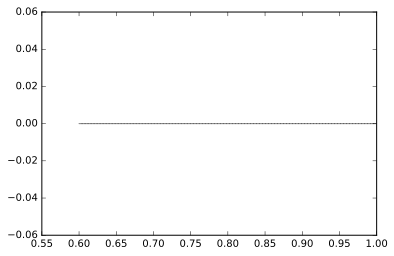

In [220]:
bins =  np.linspace(0.6, 1, 100)
#plt.hist(y_test,color='red', alpha=0.5, bins = bins);
plt.hist(y_pred,color='blue', alpha=0.5, bins=bins);

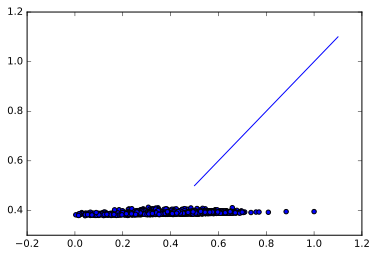

In [225]:
plt.scatter(y_test,y_pred)
xline = yline  = np.linspace(0.5,1.1, 32)
plt.plot(xline,yline)

(array([ 1.,  0.,  0., ...,  6.,  1.,  2.]),
 array([-87.15255124, -87.10692256, -87.06129388, ...,   0.59140616,
          0.63703485,   0.68266353]),
 <a list of 1925 Patch objects>)

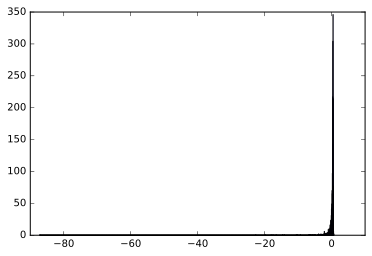

In [206]:
data  =(y_test-y_pred)/y_test#), bins='auto');
#plt.hist(np.log10(np.abs((y_test-y_pred)/y_test)), bins='auto');
plt.hist(data, bins='auto')#, bins=np.logspace(0.1, 1.0, 50))
#plt.gca().set_xscale("log")